In [44]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler, PolynomialFeatures
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error
from sklearn.ensemble import RandomForestRegressor

In [45]:
# Optional XGBoost
try:
    from xgboost import XGBRegressor
    xgb_available = True
except:
    xgb_available = False

In [46]:
df = pd.read_csv(r"C:\Users\saisr\Downloads\cars.csv")

In [47]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 205 entries, 0 to 204
Data columns (total 15 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   symboling          205 non-null    int64  
 1   normalized-losses  205 non-null    object 
 2   make               205 non-null    object 
 3   fuel-type          205 non-null    object 
 4   body-style         205 non-null    object 
 5   drive-wheels       205 non-null    object 
 6   engine-location    205 non-null    object 
 7   width              205 non-null    float64
 8   height             205 non-null    float64
 9   engine-type        205 non-null    object 
 10  engine-size        205 non-null    int64  
 11  horsepower         205 non-null    object 
 12  city-mpg           205 non-null    int64  
 13  highway-mpg        205 non-null    int64  
 14  price              205 non-null    int64  
dtypes: float64(2), int64(5), object(8)
memory usage: 24.2+ KB


In [48]:
df.isnull().sum()

symboling            0
normalized-losses    0
make                 0
fuel-type            0
body-style           0
drive-wheels         0
engine-location      0
width                0
height               0
engine-type          0
engine-size          0
horsepower           0
city-mpg             0
highway-mpg          0
price                0
dtype: int64

In [49]:
df.describe()

,symboling,width,height,engine-size,city-mpg,highway-mpg,price
count,205.000000,205.000000,205.000000,205.000000,205.000000,205.000000,205.000000
mean,0.834146,65.907805,53.724878,126.907317,25.219512,30.751220,13227.478049
std,1.245307,2.145204,2.443522,41.642693,6.542142,6.886443,7902.651615
min,-2.000000,60.300000,47.800000,61.000000,13.000000,16.000000,5118.000000
25%,0.000000,64.100000,52.000000,97.000000,19.000000,25.000000,7788.000000
50%,1.000000,65.500000,54.100000,120.000000,24.000000,30.000000,10345.000000
75%,2.000000,66.900000,55.500000,141.000000,30.000000,34.000000,16500.000000
max,3.000000,72.300000,59.800000,326.000000,49.000000,54.000000,45400.000000


In [50]:
df.replace("?", np.nan, inplace=True)
df["normalized-losses"] = pd.to_numeric(df["normalized-losses"])
df["horsepower"] = pd.to_numeric(df["horsepower"])
df.fillna(df.median(numeric_only=True), inplace=True)

In [51]:

print("\nSkewness:\n")
print(df.select_dtypes(include=np.number).skew())


Skewness:

symboling            0.211072
normalized-losses    0.976114
width                0.904003
height               0.063123
engine-size          1.947655
horsepower           1.403441
city-mpg             0.663704
highway-mpg          0.539997
price                1.805173
dtype: float64


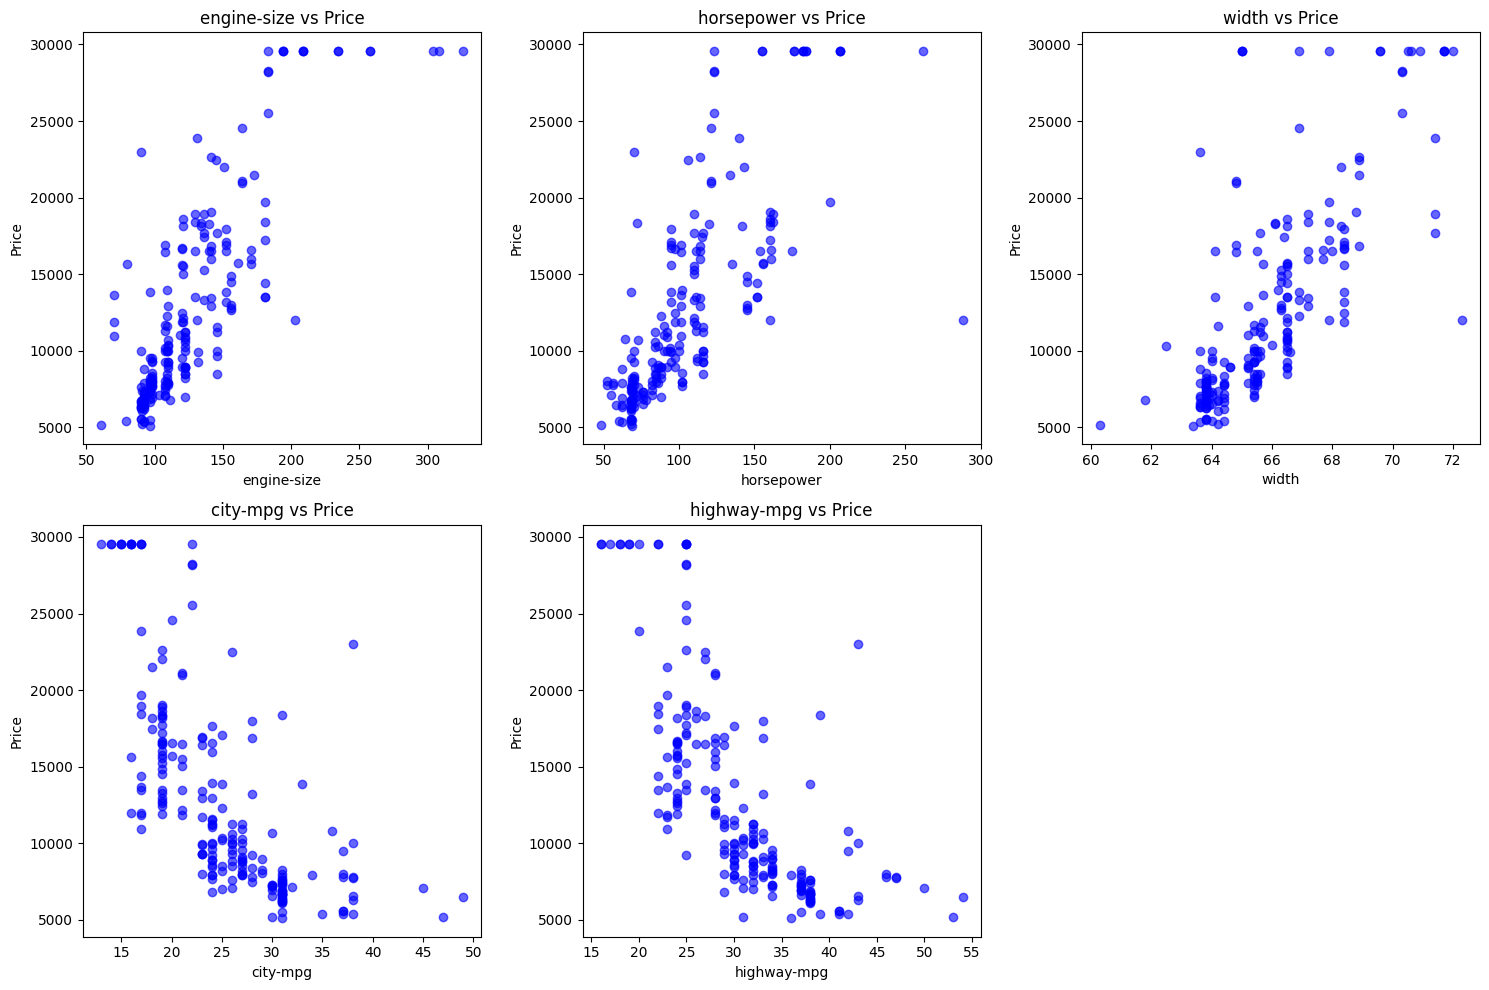

In [67]:
num_cols = ["engine-size", "horsepower", "width", "city-mpg", "highway-mpg"]

# Determine number of rows and columns for the subplot grid
rows = 2
cols = 3  # since we have 5 plots, 2x3 grid works well

fig, axes = plt.subplots(rows, cols, figsize=(15, 10))
axes = axes.flatten()  # flatten to 1D array for easy iteration

for i, col in enumerate(num_cols):
    axes[i].scatter(df[col], df["price"], color='blue', alpha=0.6)
    axes[i].set_xlabel(col)
    axes[i].set_ylabel("Price")
    axes[i].set_title(f"{col} vs Price")

# Remove any empty subplots (since 2x3 grid has 6 but we have 5 columns)
for j in range(i+1, len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.show()


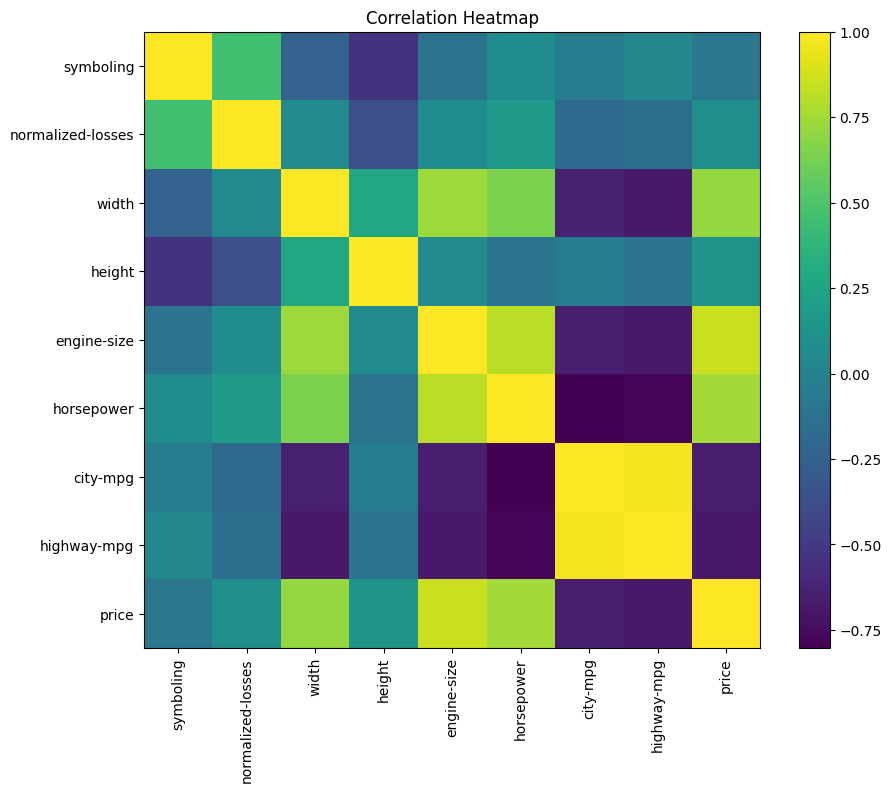

In [53]:
corr = df.select_dtypes(include=np.number).corr()

plt.figure(figsize=(10,8))
plt.imshow(corr)
plt.colorbar()
plt.xticks(range(len(corr.columns)), corr.columns, rotation=90)
plt.yticks(range(len(corr.columns)), corr.columns)
plt.title("Correlation Heatmap")
plt.show()


In [54]:
# ENCODING
# ======================

le = LabelEncoder()
for col in df.select_dtypes(include="object"):
    df[col] = le.fit_transform(df[col])

In [55]:
# FEATURE ENGINEERING
# ======================

df["avg_mpg"] = (df["city-mpg"] + df["highway-mpg"]) / 2

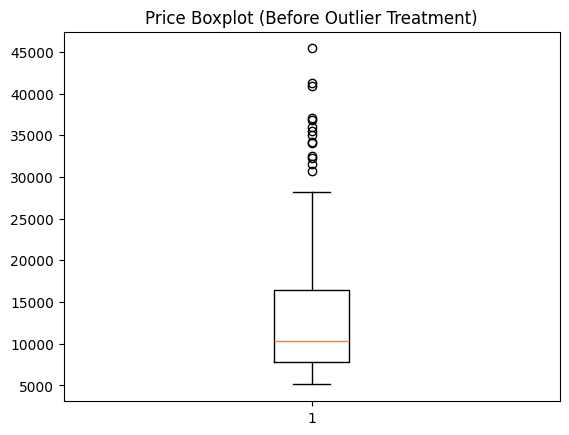

In [56]:
# Boxplot before outliers
plt.figure()
plt.boxplot(df["price"])
plt.title("Price Boxplot (Before Outlier Treatment)")
plt.show()

In [57]:
Q1 = df["price"].quantile(0.25)
Q3 = df["price"].quantile(0.75)
IQR = Q3 - Q1

lower = Q1 - 1.5 * IQR
upper = Q3 + 1.5 * IQR

print("Outliers:", df[(df["price"] < lower) | (df["price"] > upper)].shape[0])

df["price"] = np.clip(df["price"], lower, upper)

Outliers: 14


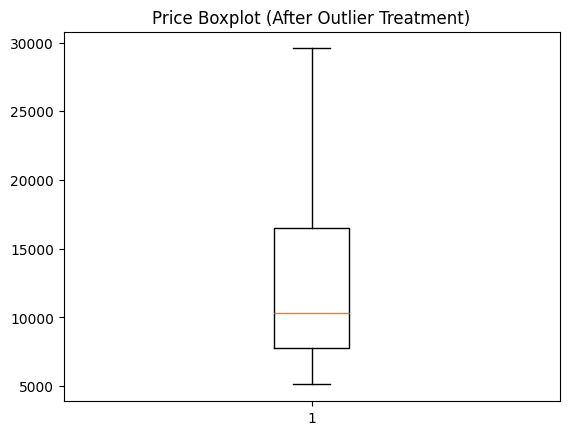

In [58]:
# Boxplot after outliers
plt.figure()
plt.boxplot(df["price"])
plt.title("Price Boxplot (After Outlier Treatment)")
plt.show()

In [59]:
X = df.drop("price", axis=1)
y = df["price"]

In [60]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

In [61]:
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

In [62]:
# POLY FEATURES


poly = PolynomialFeatures(degree=2)
X_train_poly = poly.fit_transform(X_train)
X_test_poly = poly.transform(X_test)

In [63]:
models = {
    "Linear": LinearRegression(),
    "Ridge": Ridge(alpha=1),
    "Lasso": Lasso(alpha=0.01),
    "Polynomial": LinearRegression(),
    "RandomForest": RandomForestRegressor(n_estimators=150, random_state=42)
}
if xgb_available:
    models["XGBoost"] = XGBRegressor(n_estimators=150, learning_rate=0.05, random_state=42)


In [64]:
# METRICS DICTS
# ======================

r2_scores = {}
rmse_scores = {}
mae_scores = {}
mape_scores = {}

In [65]:
for name, model in models.items():

    if name == "Polynomial":
        model.fit(X_train_poly, y_train)
        preds = model.predict(X_test_poly)
    else:
        model.fit(X_train, y_train)
        preds = model.predict(X_test)

    # Regression metrics
    r2_scores[name] = r2_score(y_test, preds)
    rmse_scores[name] = np.sqrt(mean_squared_error(y_test, preds))
    mae_scores[name] = mean_absolute_error(y_test, preds)
    mape_scores[name] = np.mean(np.abs((y_test - preds) / y_test)) * 100

    print(f"\n{name} Metrics:")
    print(f"R2: {r2_scores[name]:.4f}")
    print(f"RMSE: {rmse_scores[name]:.4f}")
    print(f"MAE: {mae_scores[name]:.4f}")
    print(f"MAPE: {mape_scores[name]:.2f}%")


Linear Metrics:
R2: 0.7083
RMSE: 3984.1368
MAE: 2585.2858
MAPE: 20.75%

Ridge Metrics:
R2: 0.7081
RMSE: 3985.7853
MAE: 2583.9014
MAPE: 20.74%

Lasso Metrics:
R2: 0.7083
RMSE: 3984.1512
MAE: 2585.3111
MAPE: 20.75%

Polynomial Metrics:
R2: -0.0554
RMSE: 7579.0601
MAE: 4326.7974
MAPE: 36.38%


C:\Users\saisr\AppData\Roaming\Python\Python313\site-packages\sklearn\linear_model\_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 7.415e+07, tolerance: 6.739e+05
  model = cd_fast.enet_coordinate_descent(



RandomForest Metrics:
R2: 0.8398
RMSE: 2953.0542
MAE: 1727.0276
MAPE: 13.64%

XGBoost Metrics:
R2: 0.8390
RMSE: 2960.4930
MAE: 1720.2979
MAPE: 13.57%


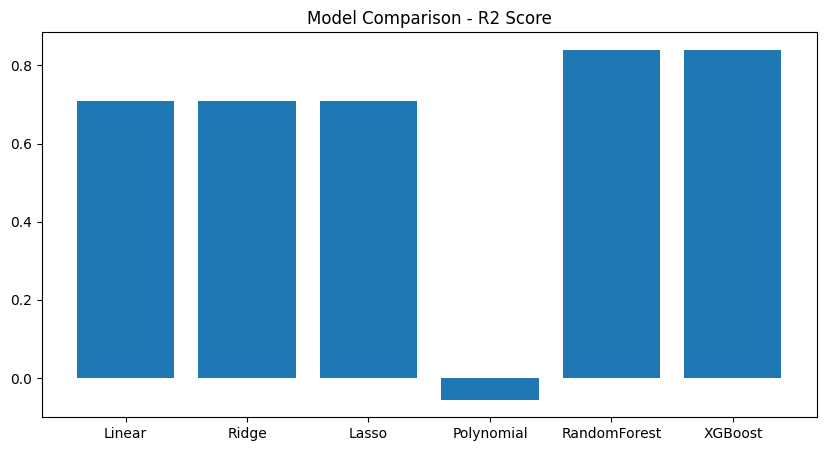

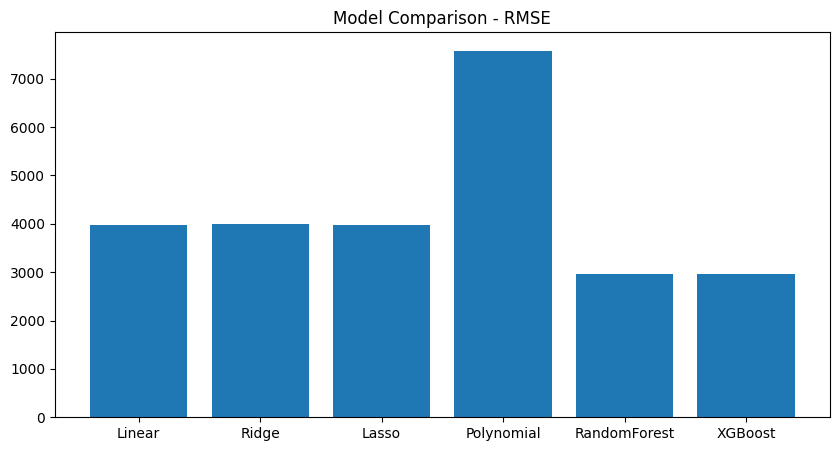

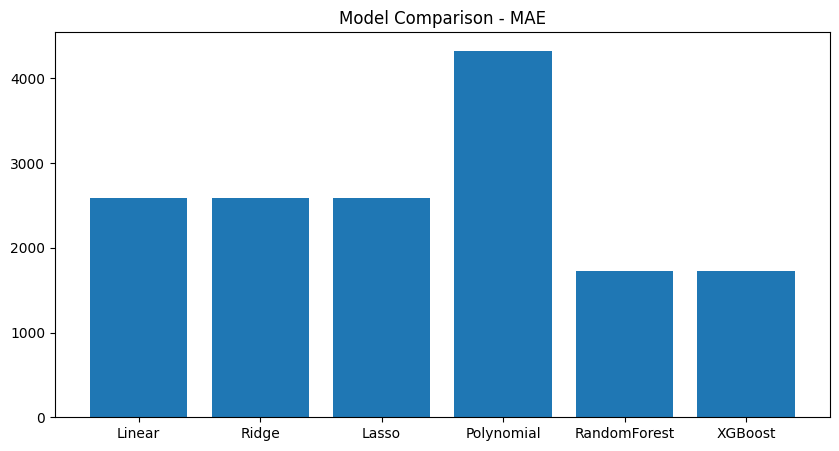

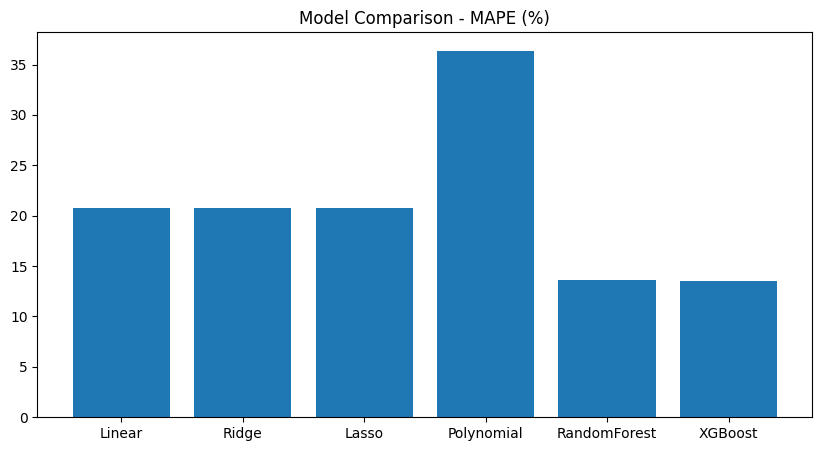

In [66]:
# ======================
# MODEL COMPARISON PLOTS
# ======================

plt.figure(figsize=(10,5))
plt.bar(r2_scores.keys(), r2_scores.values())
plt.title("Model Comparison - R2 Score")
plt.show()

plt.figure(figsize=(10,5))
plt.bar(rmse_scores.keys(), rmse_scores.values())
plt.title("Model Comparison - RMSE")
plt.show()

plt.figure(figsize=(10,5))
plt.bar(mae_scores.keys(), mae_scores.values())
plt.title("Model Comparison - MAE")
plt.show()

plt.figure(figsize=(10,5))
plt.bar(mape_scores.keys(), mape_scores.values())
plt.title("Model Comparison - MAPE (%)")
plt.show()
